In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pymc as pm

print(f"PYMC version {pm.__version__}.")

PYMC version 5.1.2.


In [11]:
# filter out Seaborn UserWarnings
import warnings
warnings.filterwarnings(
    action='ignore',
    category=UserWarning,
    module=r'seaborn'
)

In [2]:
RANDOM_SEED = 5486
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
DATA_DIR = Path("../data/")
DATA_FILE = DATA_DIR / "Howell1.csv"
assert DATA_FILE.exists()

In [4]:
humans = pd.read_csv(DATA_FILE)
humans.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [5]:
humans.describe()

,height,weight,age,male
count,544.000000,544.000000,544.000000,544.000000
mean,138.263596,35.610618,29.344393,0.472426
std,27.602448,14.719178,20.746888,0.499699
min,53.975000,4.252425,0.000000,0.000000
25%,125.095000,22.007717,12.000000,0.000000
50%,148.590000,40.057844,27.000000,0.000000
75%,157.480000,47.209005,43.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


In [8]:
az.summary(humans.to_dict(orient="list"), kind="stats", hdi_prob=.89)

,mean,sd,hdi_5.5%,hdi_94.5%
height,138.264,27.602,90.805,170.180
weight,35.611,14.719,11.368,55.707
age,29.344,20.747,0.000,57.000
male,0.472,0.500,0.000,1.000


In [9]:
humans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


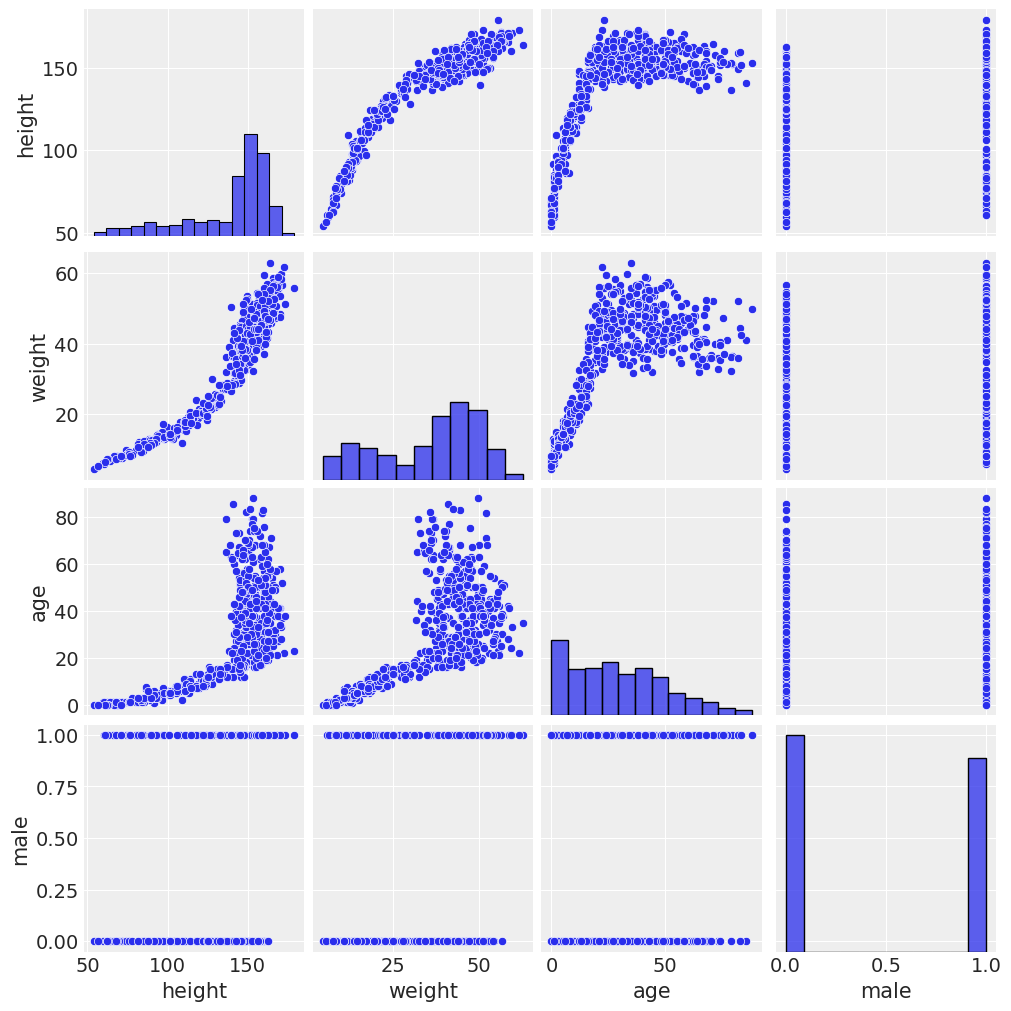

In [15]:
sns.pairplot(data=humans);

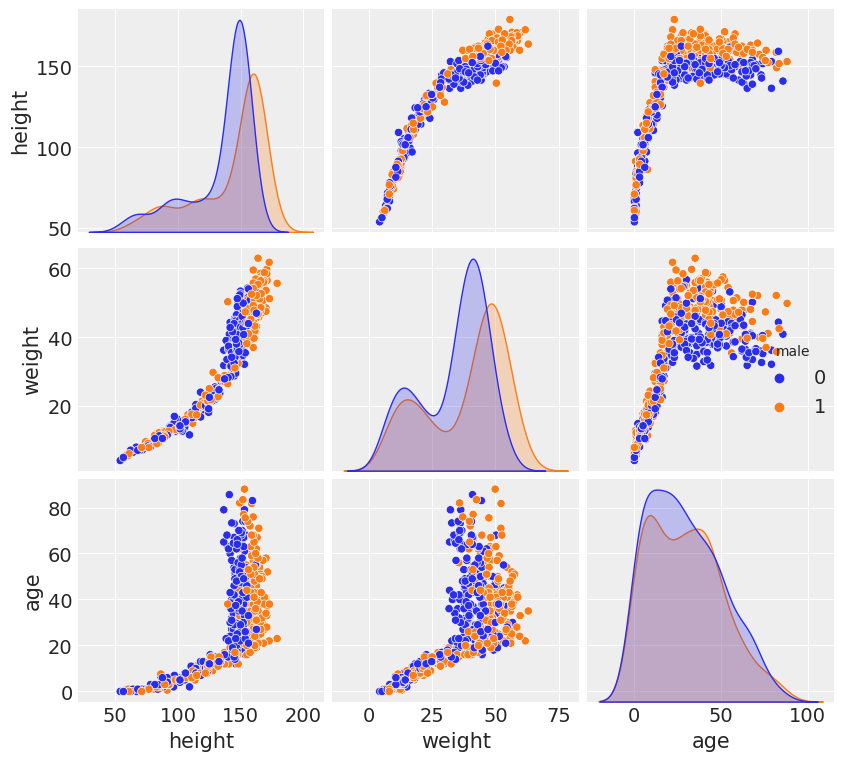

In [14]:
sns.pairplot(data=humans, hue="male");

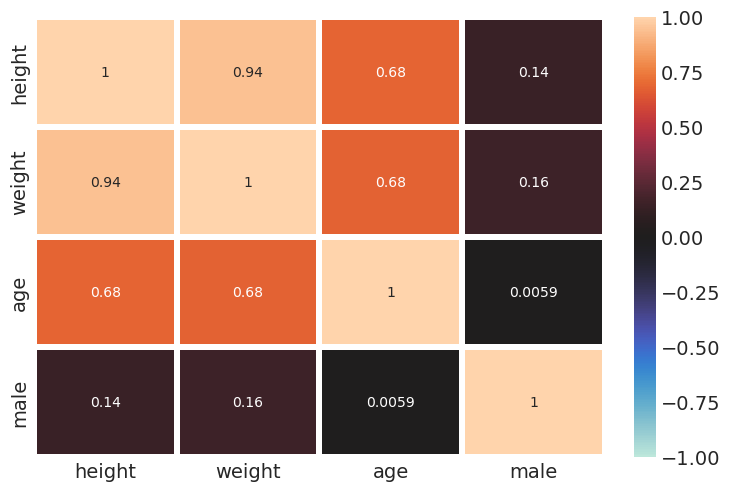

In [16]:
sns.heatmap(humans.corr(), vmin=-1, vmax=1, center=0, annot=True, linewidths=4);

In [28]:
humans_one_plus = humans[humans.age >= 1]
humans_one_plus["log_height"] = np.log(humans_one_plus.height)
humans_one_plus["log_weight"] = np.log(humans_one_plus.weight)
humans_one_plus["log_age"] = np.log(humans_one_plus.age)

/tmp/ipykernel_35485/292268738.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  humans_one_plus["log_height"] = np.log(humans_one_plus.height)
/tmp/ipykernel_35485/292268738.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  humans_one_plus["log_weight"] = np.log(humans_one_plus.weight)
/tmp/ipykernel_35485/292268738.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

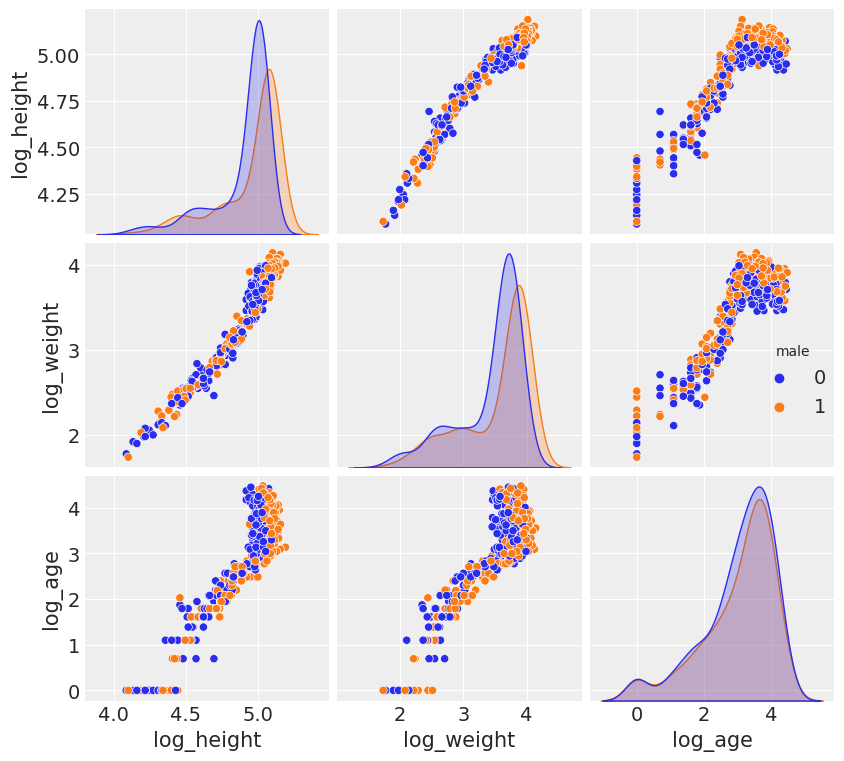

In [30]:
sns.pairplot(data=humans_one_plus[["log_height", "log_weight", "log_age", "male"]], hue="male");

In [172]:
humans_one_plus["sex"] = humans_one_plus.male + 1
humans_one_plus.head()

/tmp/ipykernel_35485/1918271830.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  humans_one_plus["sex"] = humans_one_plus.male + 1


,height,weight,age,male,log_height,log_weight,log_age,sex
0,151.765,47.825606,63.0,1,5.022333,3.867561,4.143135,2
1,139.700,36.485807,63.0,0,4.939497,3.596923,4.143135,1
2,136.525,31.864838,65.0,0,4.916508,3.461503,4.174387,1
3,156.845,53.041914,41.0,1,5.055258,3.971082,3.713572,2
4,145.415,41.276872,51.0,0,4.979592,3.720302,3.931826,1


In [185]:
sex_idx, sex = humans_one_plus.sex.factorize(sort=True)
COORDS = {
    "slopes": ["height"],
    "sex": sex,
}

In [186]:
with pm.Model(coords=COORDS) as simple_model:
    # data
    log_height = pm.ConstantData("log_height", humans_one_plus.log_height.values)
    log_weight = pm.ConstantData("log_weight", humans_one_plus.log_weight.values)

    # priors 
    intercept = pm.Normal("intercept", mu=10, sigma=1)
    theta = pm.Normal("theta", mu=0, sigma=1, dims=[("slopes")])
    sigma = pm.HalfNormal("sigma", 1.0)

    mu = intercept + theta * log_height
    log_likelihood = pm.Normal("weight", mu=mu, sigma=sigma, observed=log_weight)

    idata_simple = pm.sample()
    idata_simple.extend(pm.sample_prior_predictive())
    idata_simple.extend(pm.sample_posterior_predictive(idata_simple))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, theta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
Sampling: [intercept, sigma, theta, weight]


In [187]:
az.summary(idata_simple, hdi_prob=.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-8.043,0.122,-8.241,-7.853,0.004,0.003,990.0,1169.0,1.0
theta[height],2.341,0.025,2.303,2.382,0.001,0.001,993.0,1238.0,1.0
sigma,0.123,0.004,0.117,0.129,0.000,0.000,1692.0,1672.0,1.0


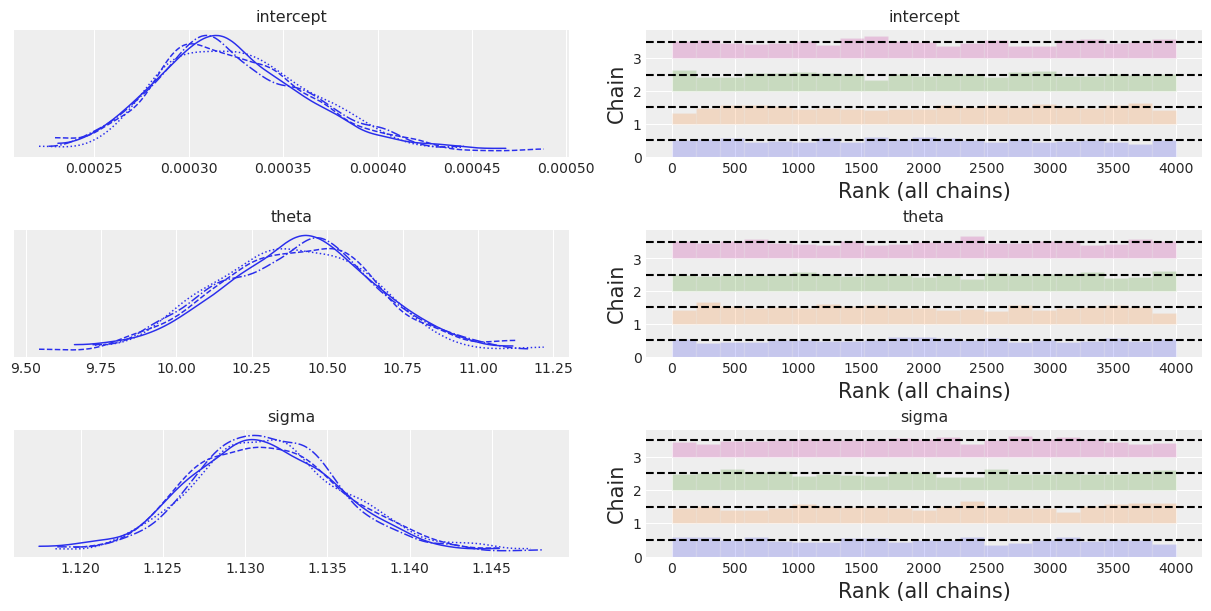

In [188]:
az.plot_trace(idata_simple, transform=np.exp, kind="rank_bars");

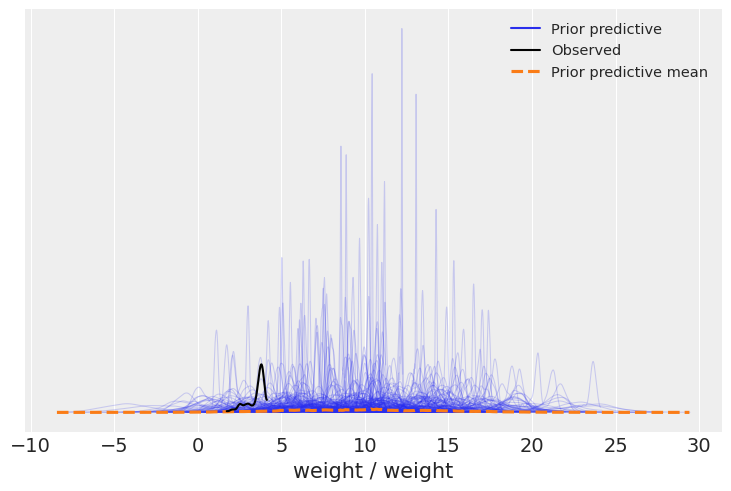

In [189]:
az.plot_ppc(idata_simple, group="prior", observed=True);

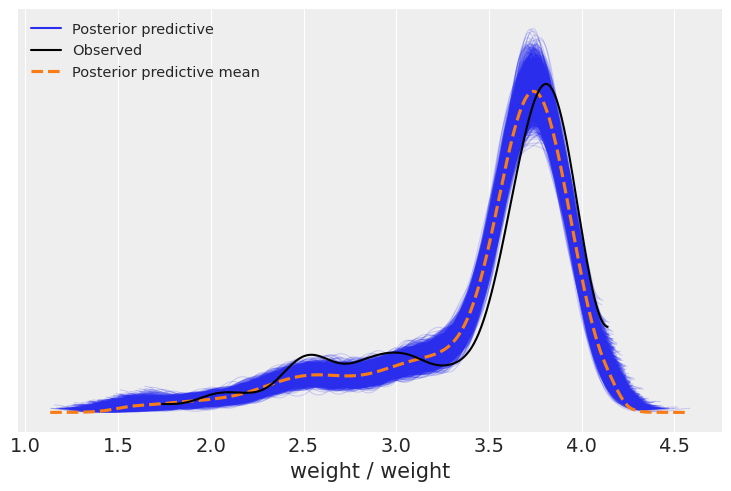

In [190]:
az.plot_ppc(idata_simple);

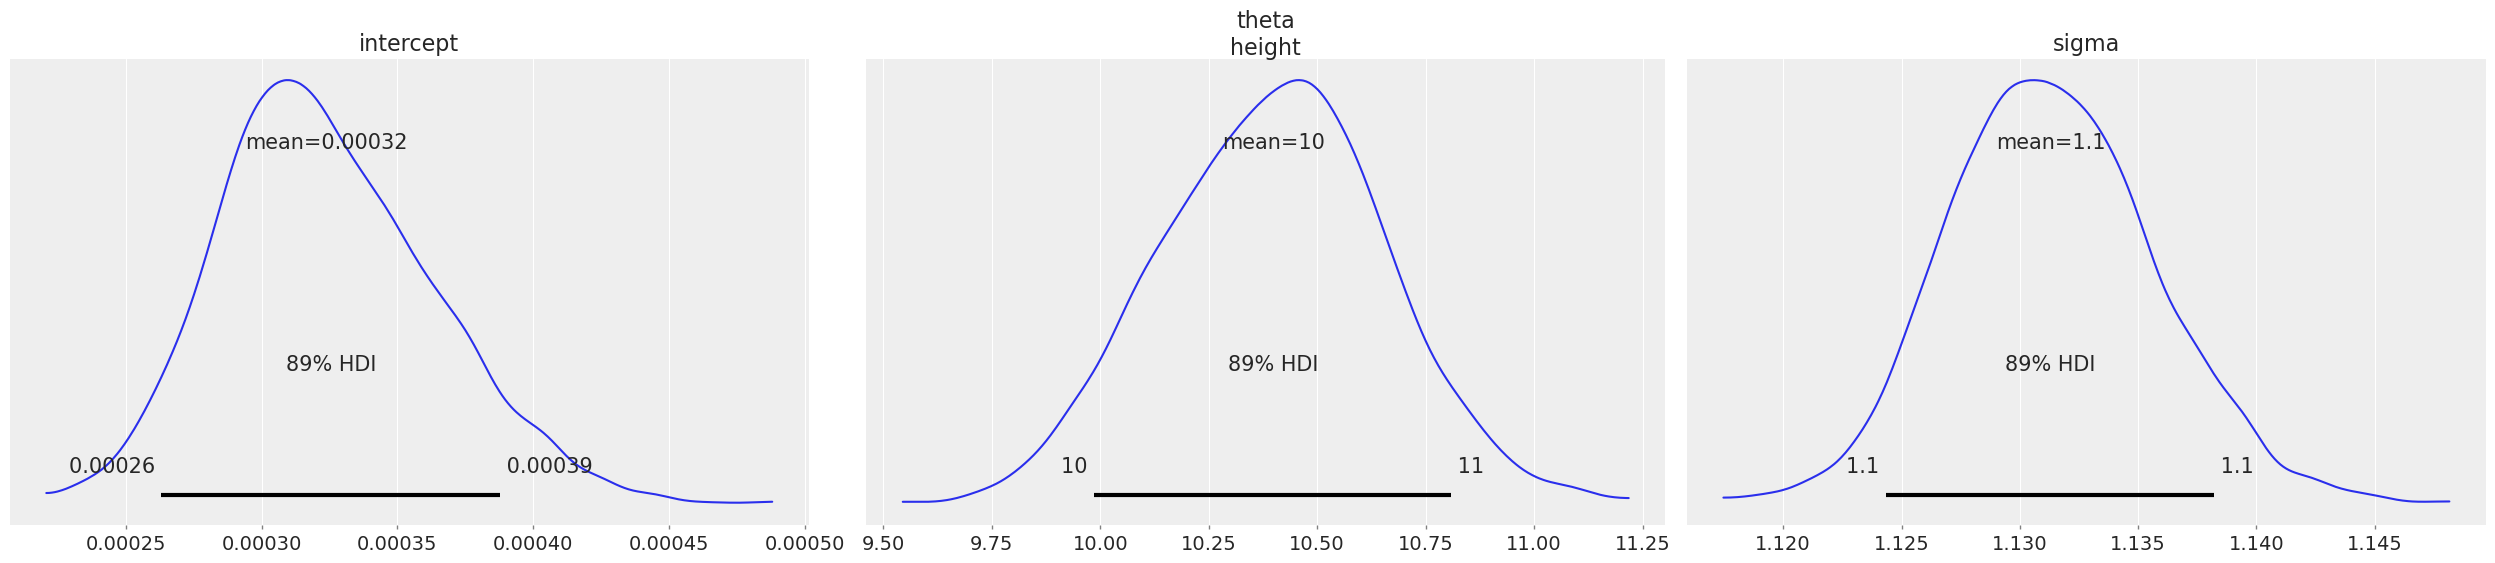

In [191]:
az.plot_posterior(idata_simple, hdi_prob=.89, transform=np.exp);

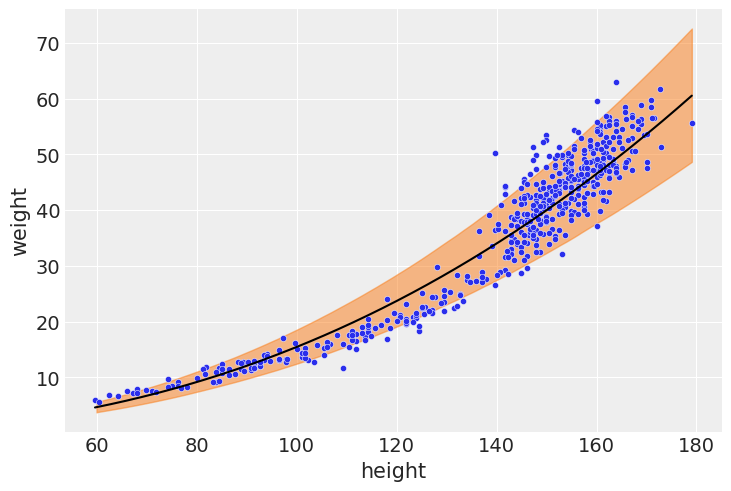

In [192]:
mean_weight = (
    idata_simple.posterior.intercept.mean(("chain", "draw")).data 
    + idata_simple.posterior.theta.mean(("chain", "draw")).data * (np.linspace(min(humans_one_plus.log_height),max(humans_one_plus.log_height),1000))
    # + idata_simple.posterior.theta.mean(("chain", "draw")).data[1] * (np.linspace(min(humans_one_plus.log_age),max(humans_one_plus.log_age),1000))
)
az.plot_hdi(humans_one_plus.height, np.exp(idata_simple.posterior_predictive.weight), hdi_prob=0.89)
sns.scatterplot(data=humans_one_plus, x="height", y="weight", s=20);
plt.plot(np.exp(np.linspace(min(humans_one_plus.log_height),max(humans_one_plus.log_height),1000)), np.exp(mean_weight),'k')



In [193]:
idata_simple.posterior.intercept.mean(("chain", "draw")).data

array(-8.04283841)

In [194]:
idata_simple.posterior.theta.mean(("chain", "draw")).data

array([2.34134773])

In [197]:
with pm.Model(coords=COORDS) as cat_model:
    # data
    log_height = pm.ConstantData("log_height", humans_one_plus.log_height.values)
    # log_age = pm.ConstantData("log_age", humans_one_plus.log_age.values)
    log_weight = pm.ConstantData("log_weight", humans_one_plus.log_weight.values)
    sex_idx_ = pm.ConstantData("sex_idx", sex_idx)

    # priors 
    intercept = pm.Normal("intercept", mu=10, sigma=1, dims="sex")
    theta = pm.Normal("theta", mu=0, sigma=1, dims="sex")
    sigma = pm.HalfNormal("sigma", 1.0)

    mu = intercept[sex_idx_] + theta[sex_idx_] * log_height # + theta[sex_idx_, 1] * log_age
    log_likelihood = pm.Normal("weight", mu=mu, sigma=sigma, observed=log_weight)

    idata_cat = pm.sample()
    idata_cat.extend(pm.sample_prior_predictive())
    idata_cat.extend(pm.sample_posterior_predictive(idata_cat))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, theta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
Sampling: [intercept, sigma, theta, weight]


In [198]:
az.summary(idata_cat, hdi_prob=.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept[1],-7.759,0.184,-8.041,-7.459,0.005,0.003,1551.0,1866.0,1.0
intercept[2],-7.767,0.176,-8.061,-7.501,0.004,0.003,1594.0,1822.0,1.0
theta[1],2.284,0.038,2.228,2.347,0.001,0.001,1555.0,1880.0,1.0
theta[2],2.285,0.036,2.232,2.345,0.001,0.001,1598.0,1896.0,1.0
sigma,0.125,0.004,0.118,0.132,0.000,0.000,2202.0,2090.0,1.0


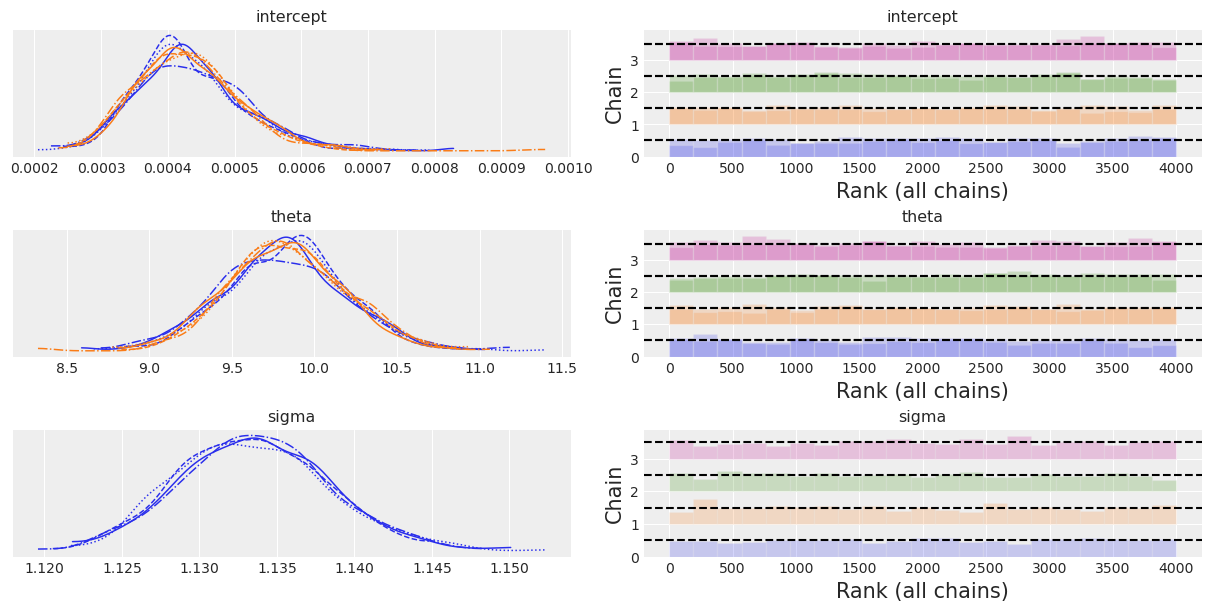

In [199]:
az.plot_trace(idata_cat, transform=np.exp, kind="rank_bars");

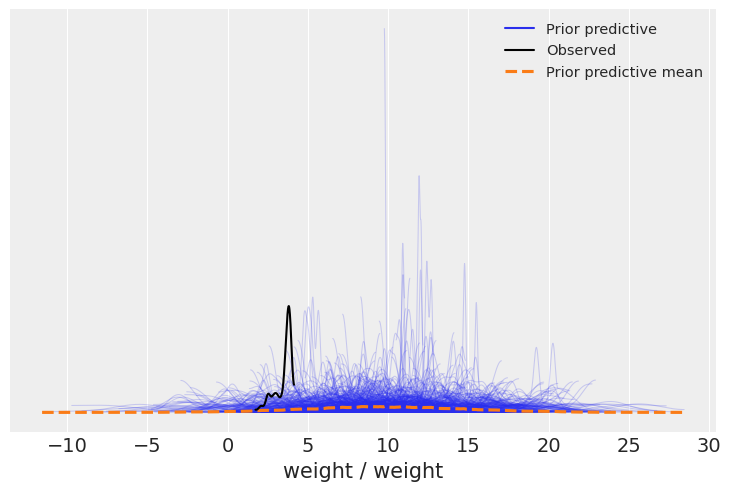

In [200]:
az.plot_ppc(idata_cat, group="prior", observed=True);

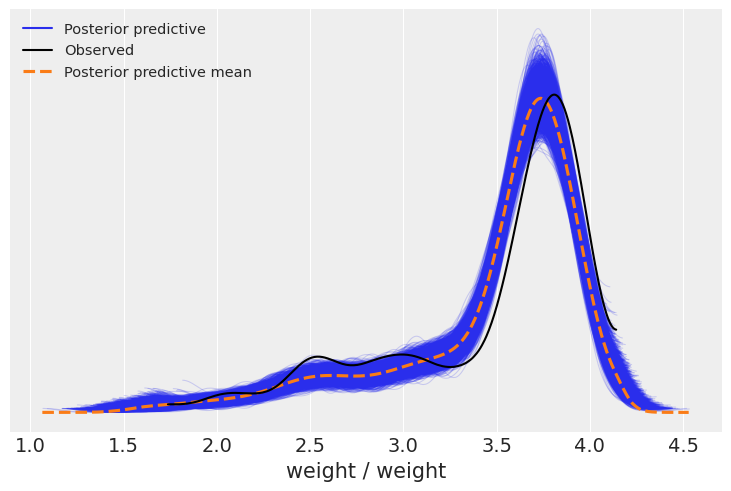

In [201]:
az.plot_ppc(idata_cat);

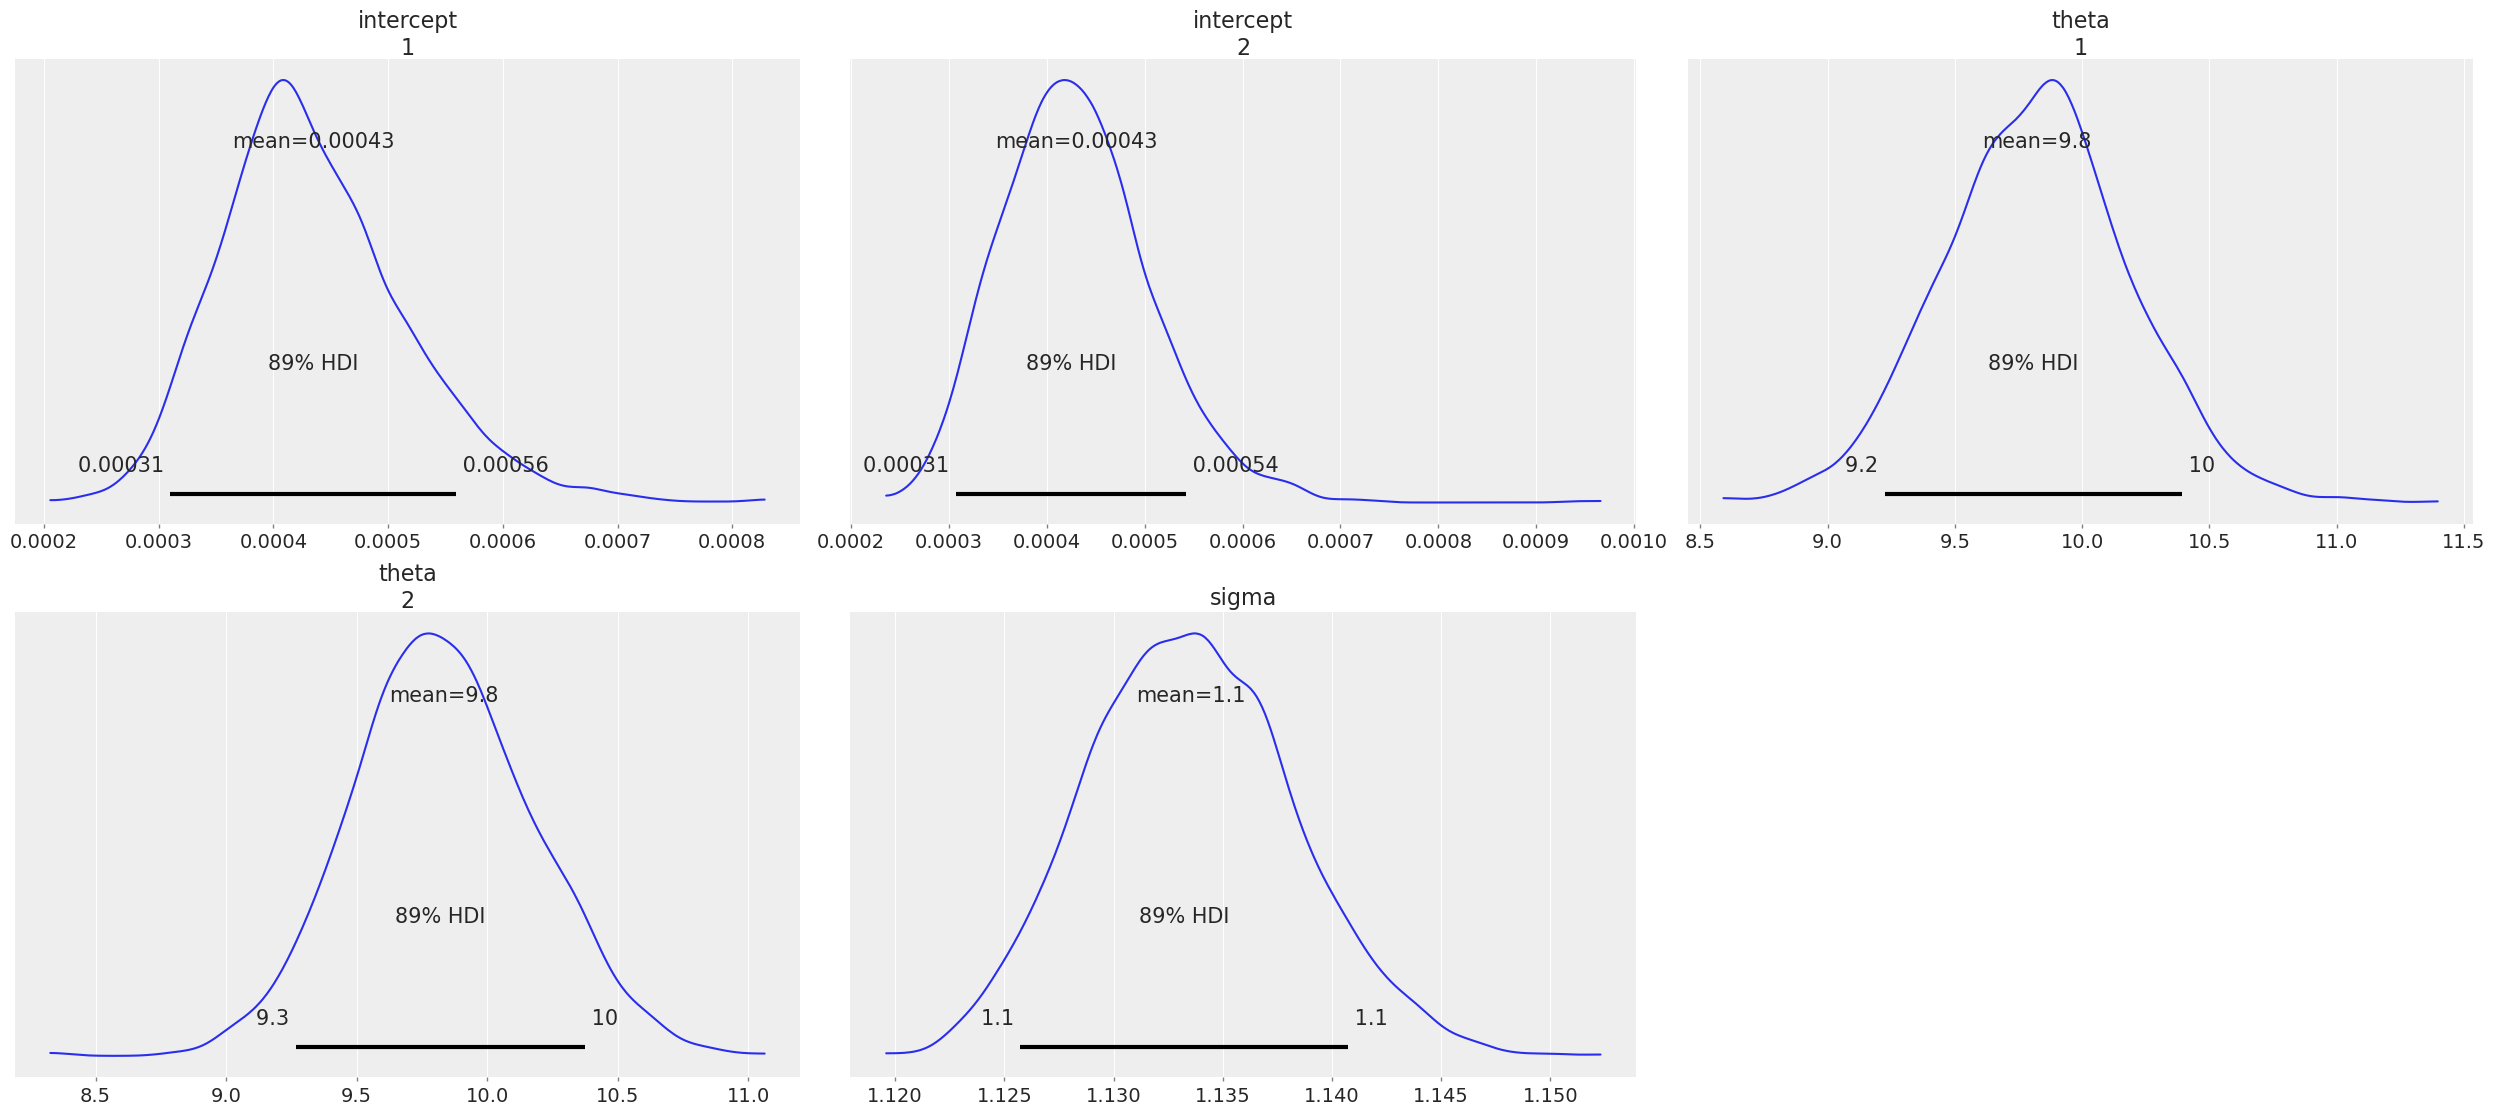

In [202]:
az.plot_posterior(idata_cat, hdi_prob=.89, transform=np.exp);

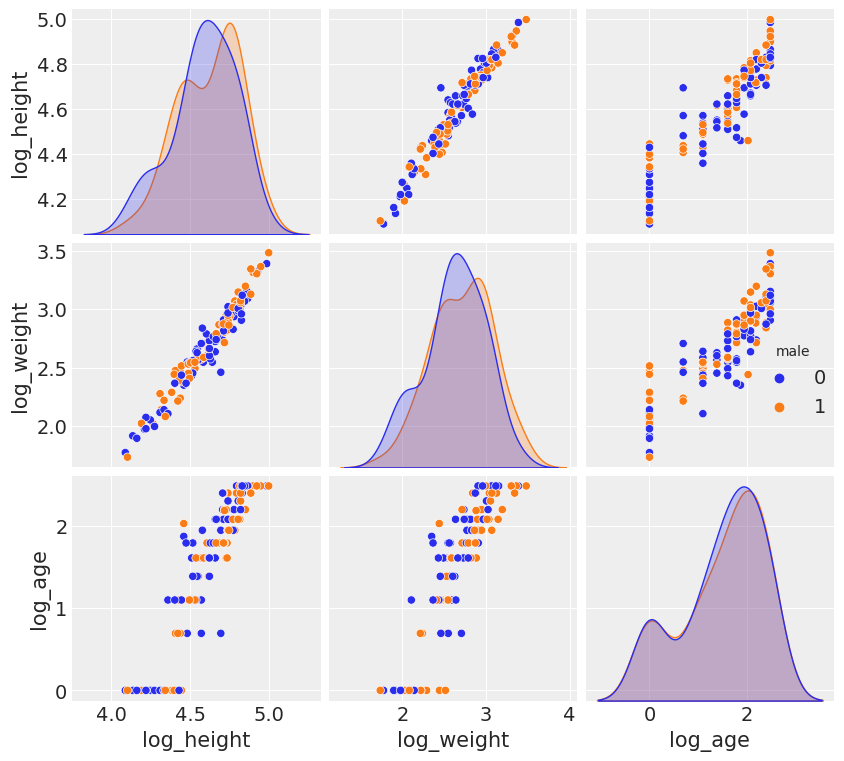

In [205]:
child = humans_one_plus[humans_one_plus.age < 13]
sns.pairplot(data=child[["log_height", "log_weight", "log_age", "male"]], hue="male");

In [206]:
sex_idx, sex = child.sex.factorize(sort=True)
COORDS = {
    "slopes": ["height"],
    "sex": sex,
}

In [209]:
with pm.Model(coords=COORDS) as child_model:
    # data
    log_height = pm.ConstantData("log_height", child.log_height.values)
    # log_age = pm.ConstantData("log_age", humans_one_plus.log_age.values)
    log_weight = pm.ConstantData("log_weight", child.log_weight.values)
    sex_idx_ = pm.ConstantData("sex_idx", sex_idx)

    # priors 
    intercept = pm.Normal("intercept", mu=10, sigma=1, dims="sex")
    theta = pm.Normal("theta", mu=0, sigma=1, dims="sex")
    sigma = pm.HalfNormal("sigma", 1.0)

    mu = intercept[sex_idx_] + theta[sex_idx_] * log_height # + theta[sex_idx_, 1] * log_age
    log_likelihood = pm.Normal("weight", mu=mu, sigma=sigma, observed=log_weight)

    idata_child = pm.sample()
    idata_child.extend(pm.sample_prior_predictive())
    idata_child.extend(pm.sample_posterior_predictive(idata_child))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, theta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
Sampling: [intercept, sigma, theta, weight]


In [210]:
az.summary(idata_child, hdi_prob=.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept[1],-4.332,0.292,-4.804,-3.885,0.010,0.007,880.0,1293.0,1.0
intercept[2],-4.562,0.320,-5.081,-4.083,0.010,0.007,1017.0,1221.0,1.0
theta[1],1.517,0.063,1.419,1.618,0.002,0.002,884.0,1327.0,1.0
theta[2],1.575,0.069,1.471,1.687,0.002,0.002,1013.0,1179.0,1.0
sigma,0.094,0.008,0.082,0.107,0.000,0.000,1053.0,1074.0,1.0


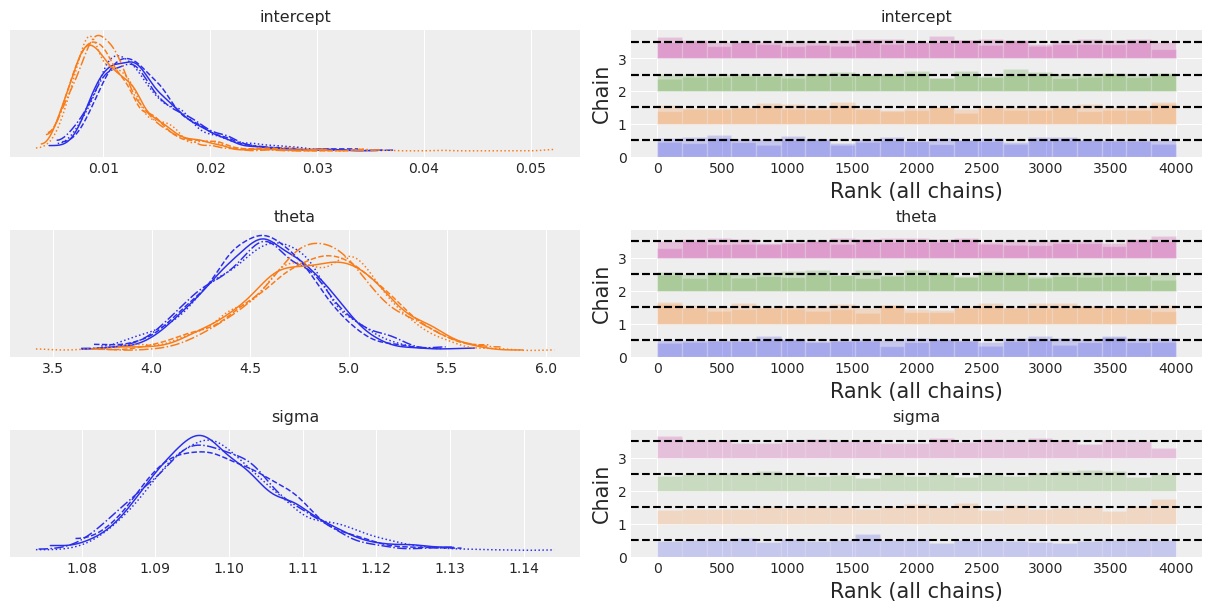

In [211]:
az.plot_trace(idata_child, transform=np.exp, kind="rank_bars");

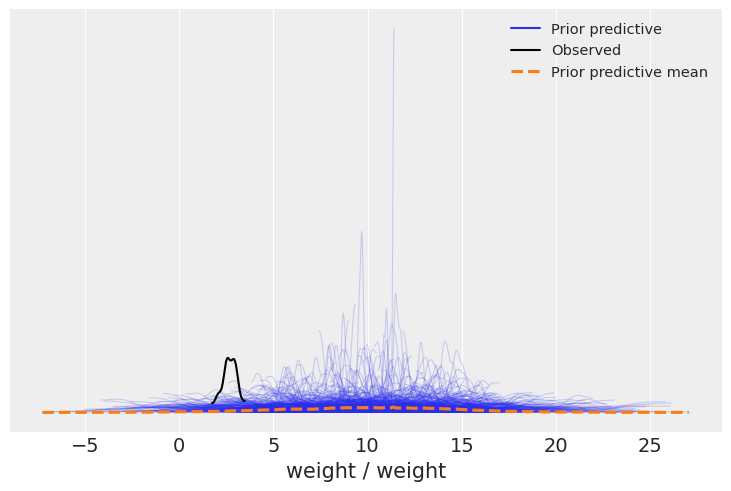

In [212]:
az.plot_ppc(idata_child, group="prior", observed=True);

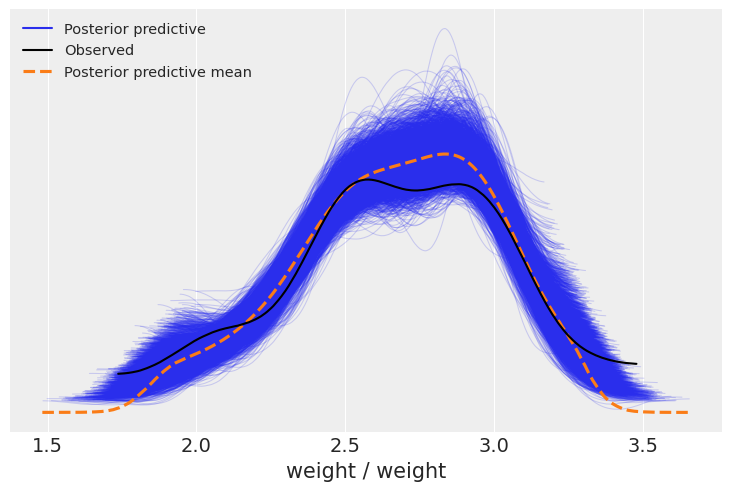

In [213]:
az.plot_ppc(idata_child);

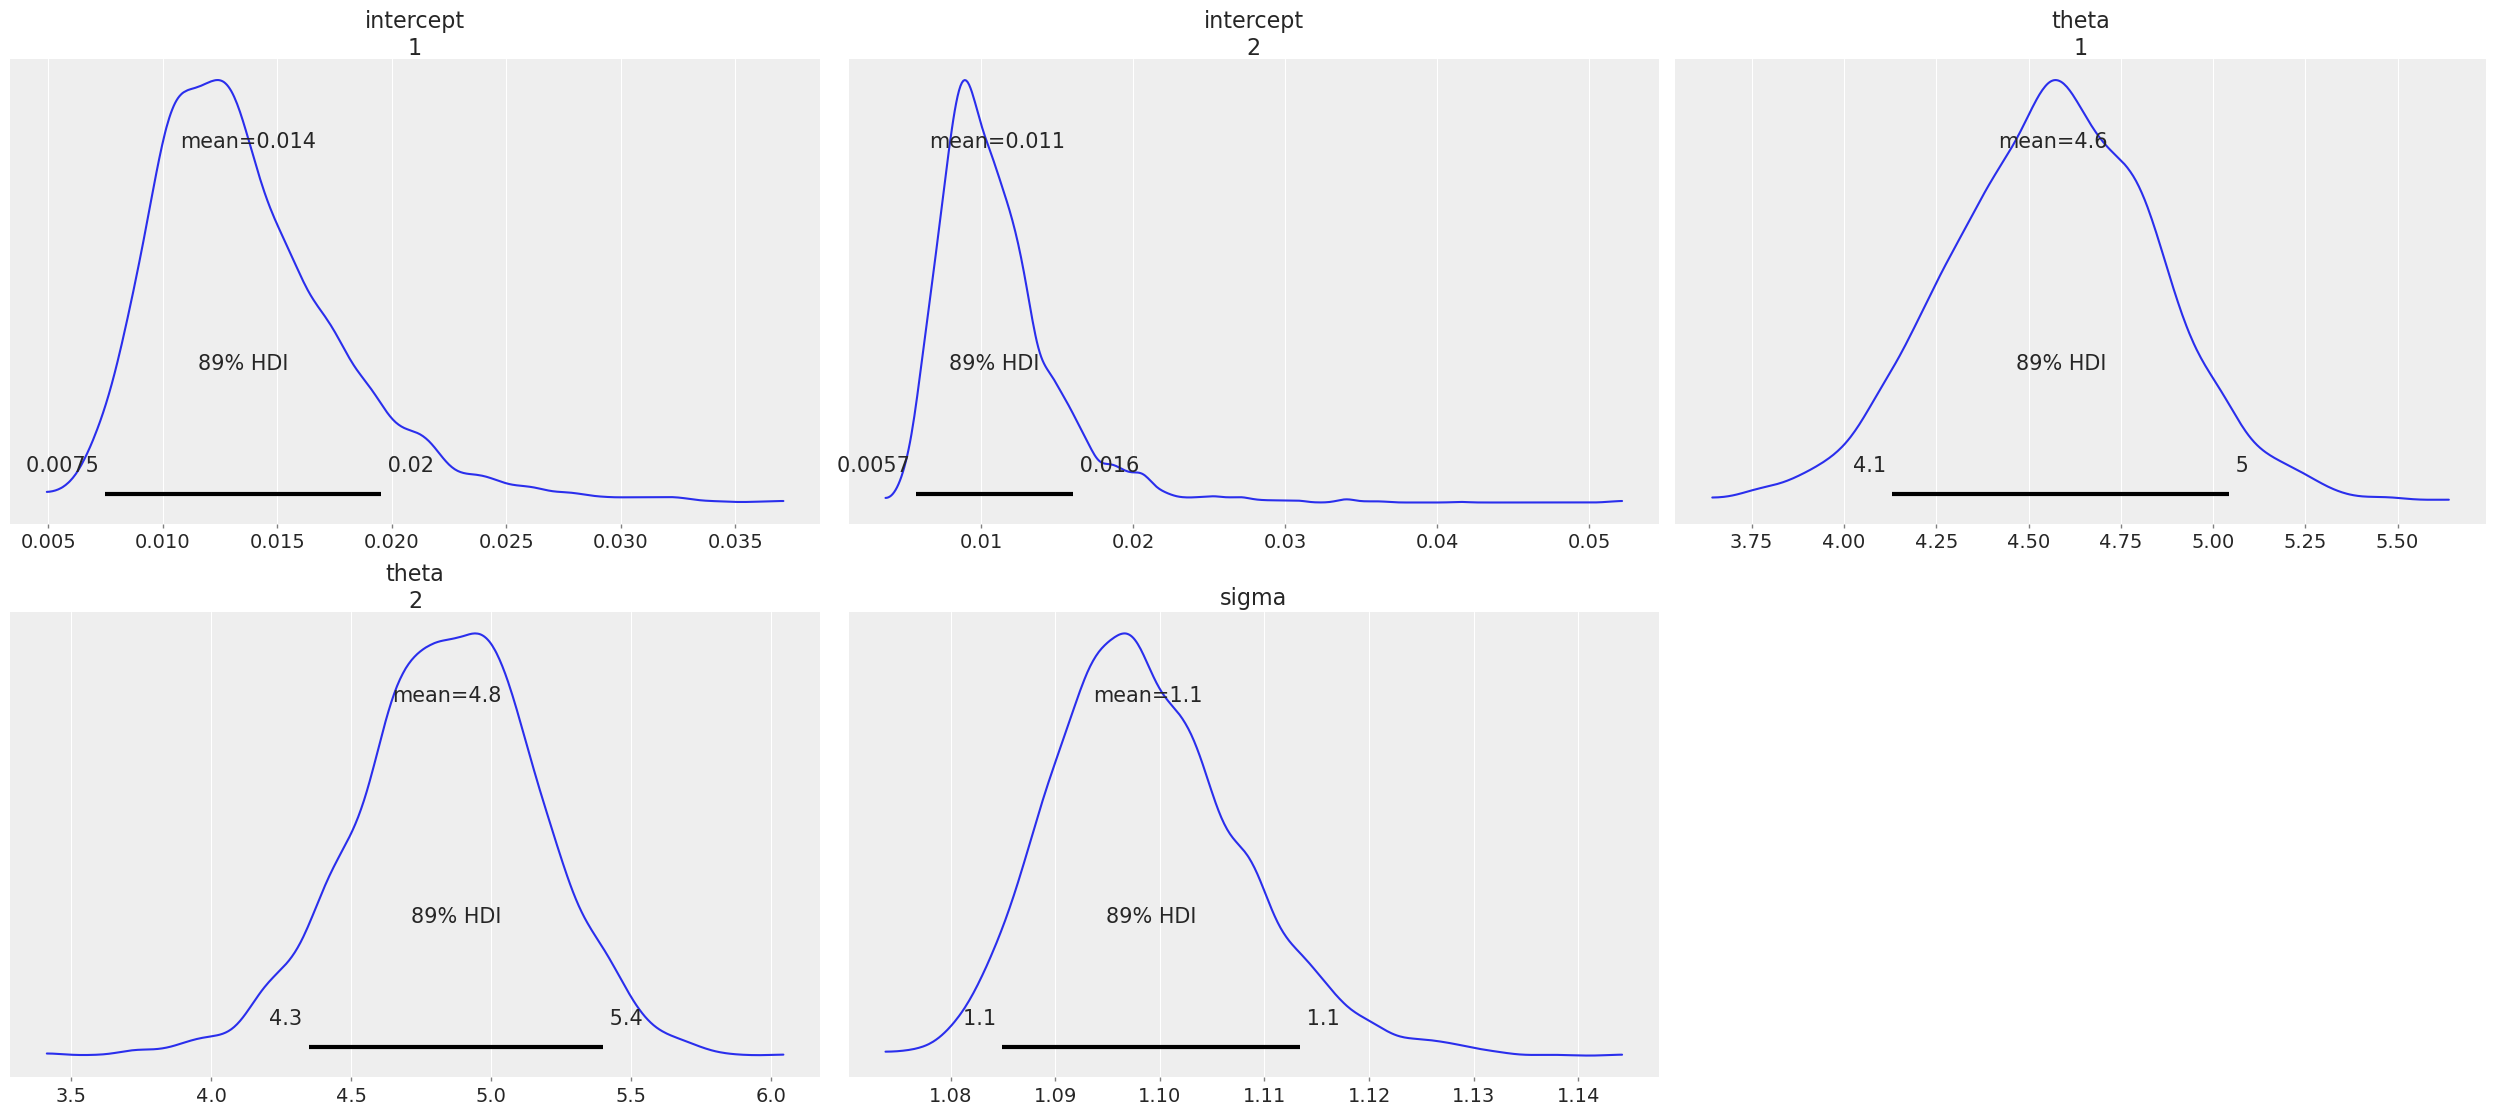

In [214]:
az.plot_posterior(idata_child, hdi_prob=.89, transform=np.exp);

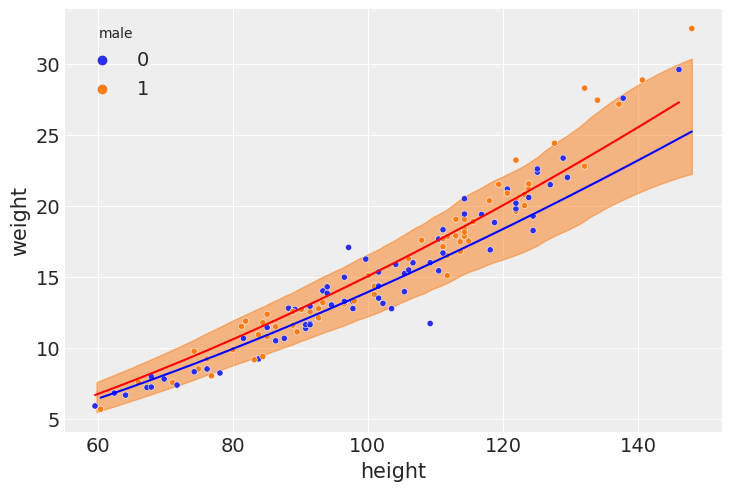

In [226]:
mean_female = (
    idata_child.posterior.intercept.mean(("chain", "draw")).data[1] 
    + idata_child.posterior.theta.mean(("chain", "draw")).data[1] * (np.linspace(min(child[child.sex == 2].log_height),max(child[child.sex == 2].log_height),1000))
)
mean_male = (
    idata_child.posterior.intercept.mean(("chain", "draw")).data[0] 
    + idata_child.posterior.theta.mean(("chain", "draw")).data[0] * (np.linspace(min(child[child.sex == 1].log_height),max(child[child.sex == 1].log_height),1000))
)
az.plot_hdi(child.height, np.exp(idata_child.posterior_predictive.weight), hdi_prob=0.89)
sns.scatterplot(data=child, x="height", y="weight", s=20, hue="male");
plt.plot(np.exp(np.linspace(min(child[child.sex == 2].log_height),max(child[child.sex == 2].log_height),1000)), np.exp(mean_male),'-b')
plt.plot(np.exp(np.linspace(min(child[child.sex == 1].log_height),max(child[child.sex == 1].log_height),1000)), np.exp(mean_female),'-r')

In [222]:
mean_male

array([1.89708303, 1.89849385, 1.89990468, 1.90131551, 1.90272634,
       1.90413717, 1.905548  , 1.90695882, 1.90836965, 1.90978048,
       1.91119131, 1.91260214, 1.91401297, 1.91542379, 1.91683462,
       1.91824545, 1.91965628, 1.92106711, 1.92247794, 1.92388877,
       1.92529959, 1.92671042, 1.92812125, 1.92953208, 1.93094291,
       1.93235374, 1.93376456, 1.93517539, 1.93658622, 1.93799705,
       1.93940788, 1.94081871, 1.94222954, 1.94364036, 1.94505119,
       1.94646202, 1.94787285, 1.94928368, 1.95069451, 1.95210533,
       1.95351616, 1.95492699, 1.95633782, 1.95774865, 1.95915948,
       1.9605703 , 1.96198113, 1.96339196, 1.96480279, 1.96621362,
       1.96762445, 1.96903528, 1.9704461 , 1.97185693, 1.97326776,
       1.97467859, 1.97608942, 1.97750025, 1.97891107, 1.9803219 ,
       1.98173273, 1.98314356, 1.98455439, 1.98596522, 1.98737605,
       1.98878687, 1.9901977 , 1.99160853, 1.99301936, 1.99443019,
       1.99584102, 1.99725184, 1.99866267, 2.0000735 , 2.00148